<a href="https://colab.research.google.com/github/aviaga/FutureMakers/blob/main/Day%2016%20(7-21)%20-%20Project%20on%20Facial%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Intro

This is the implementation of Day 16's Action Item for SureStart's summer program, 2021.

The goal of this activity is to develop a model that can classify certain characteristics of a person (gender, race, etc..) given their face as an input to the model.

The tutorial for this model development activity can be found [here](https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn/data#Getting-Started)



***Basic Info*** 

The dataset has these attributes/parameters:
- People with ages 1 to 116
- Ethnicity, with 0 corresponding to White, 1 mapping to Black, 2 for Asian, 3 for Indian, and 4 for Other
- Gender, with 0 corresponding to male and 1 mapping to female



**Data Preparation**

In [8]:
#Importing libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random


# Set Seed
np.random.seed(11)
set_seed(11)
random.seed(11)

In [11]:
#Importing dataset
from google.colab import files
uploaded = files.upload()

Saving age_gender.csv to age_gender.csv


In [12]:
#Importing dataset
import io
age_gender_data = pd.read_csv(io.BytesIO(uploaded['age_gender.csv']))

In [14]:
#Looking at the data in chart format
age_gender_data.head

<bound method NDFrame.head of        age  ...                                             pixels
0        1  ...  129 128 128 126 127 130 133 135 139 142 145 14...
1        1  ...  164 74 111 168 169 171 175 182 184 188 193 199...
2        1  ...  67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3        1  ...  193 197 198 200 199 200 202 203 204 205 208 21...
4        1  ...  202 205 209 210 209 209 210 211 212 214 218 21...
...    ...  ...                                                ...
23700   99  ...  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701   99  ...  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702   99  ...  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703   99  ...  45 108 120 156 206 197 140 180 191 199 204 207...
23704   99  ...  156 161 160 165 170 173 166 177 183 191 187 18...

[23705 rows x 5 columns]>

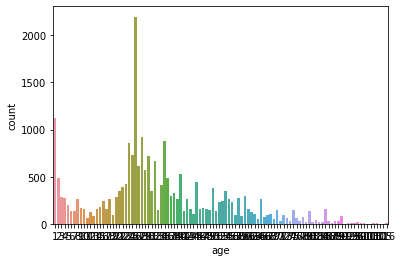

In [15]:
#Visualization of age distribution in data 
sns.countplot(x='age', data=age_gender_data) 

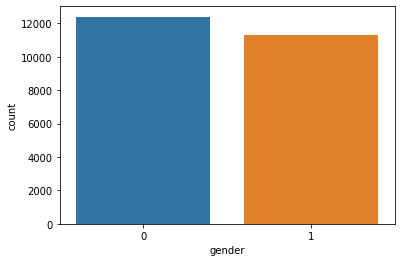

In [16]:
#Visualization of gender distribution in data
sns.countplot(x='gender', data=age_gender_data) 

**Data Preprocessing**

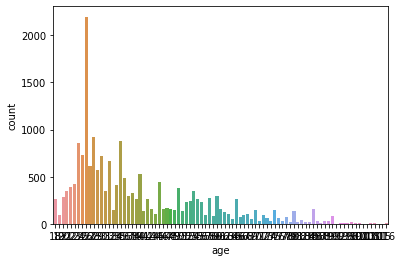

In [17]:
#Selection of those with age 18+ and visualization in graph format
age_gender_data = age_gender_data[age_gender_data['age'] >= 18]
sns.countplot(x='age', data=age_gender_data)

In [18]:
#Selection of those with age 18+ cont'd w/ visualization in table format
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [19]:
#Checking for null data
age_gender_data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [20]:
# Input image configuration
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [23]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy()
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()



In [24]:
# Splitting the data into train and te sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

In [26]:
# Converting pixel data into an array of pixels (image)
def str_to_npArr(x):
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32"))
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))


Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [31]:
#Visualizing the pixel arrays and data for the iamge
target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [32]:
#Converting data to numpy array (some parts rewritten for clarity) and normalization
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) 
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])


print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [50]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

**Data Visualization**

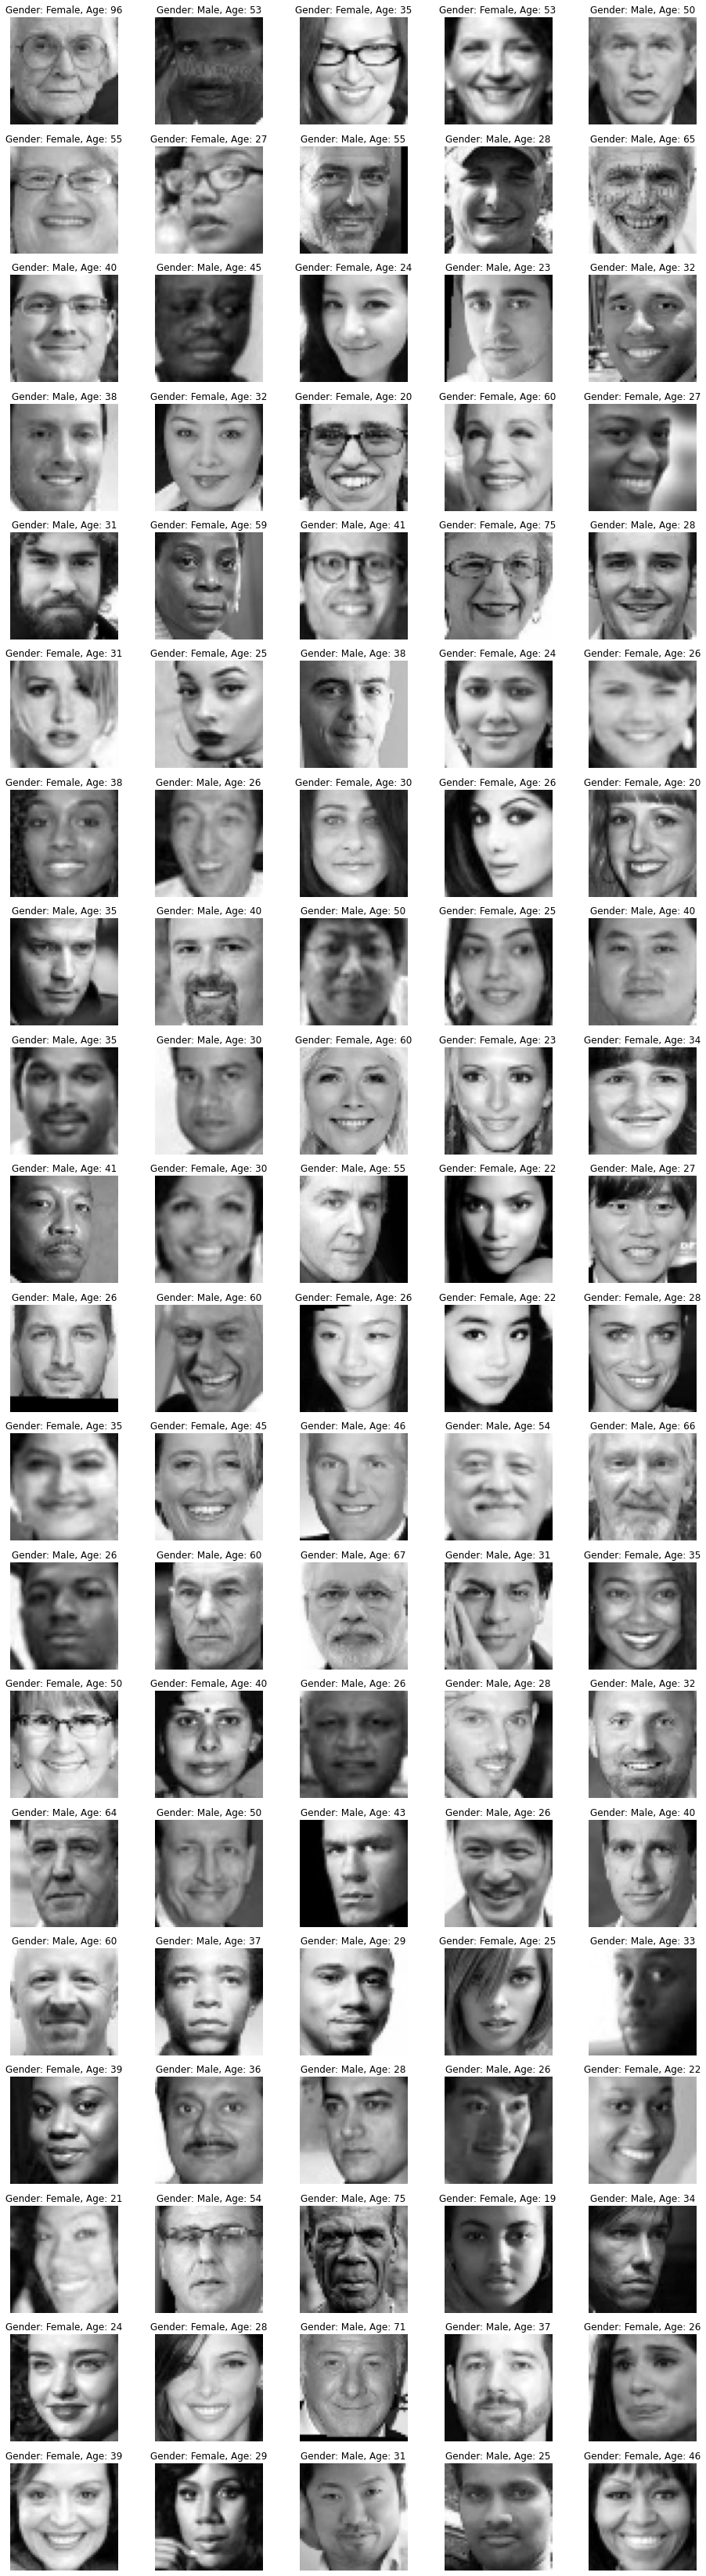

In [51]:
#Plotting data for random selection of 100 people/samples in a 20 by 5 grid
rows = 20 
cols = 5 
samp = random.sample(range(X.shape[0]),rows*cols)
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

**Data Augmentation**

In [52]:
train_data_gen = ImageDataGenerator(rotation_range=30, width_shift_range=1,brightness_range=[0.8,1.2], zoom_range=[0.8,1.2], rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [53]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val, seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test, seed=11,shuffle=False)

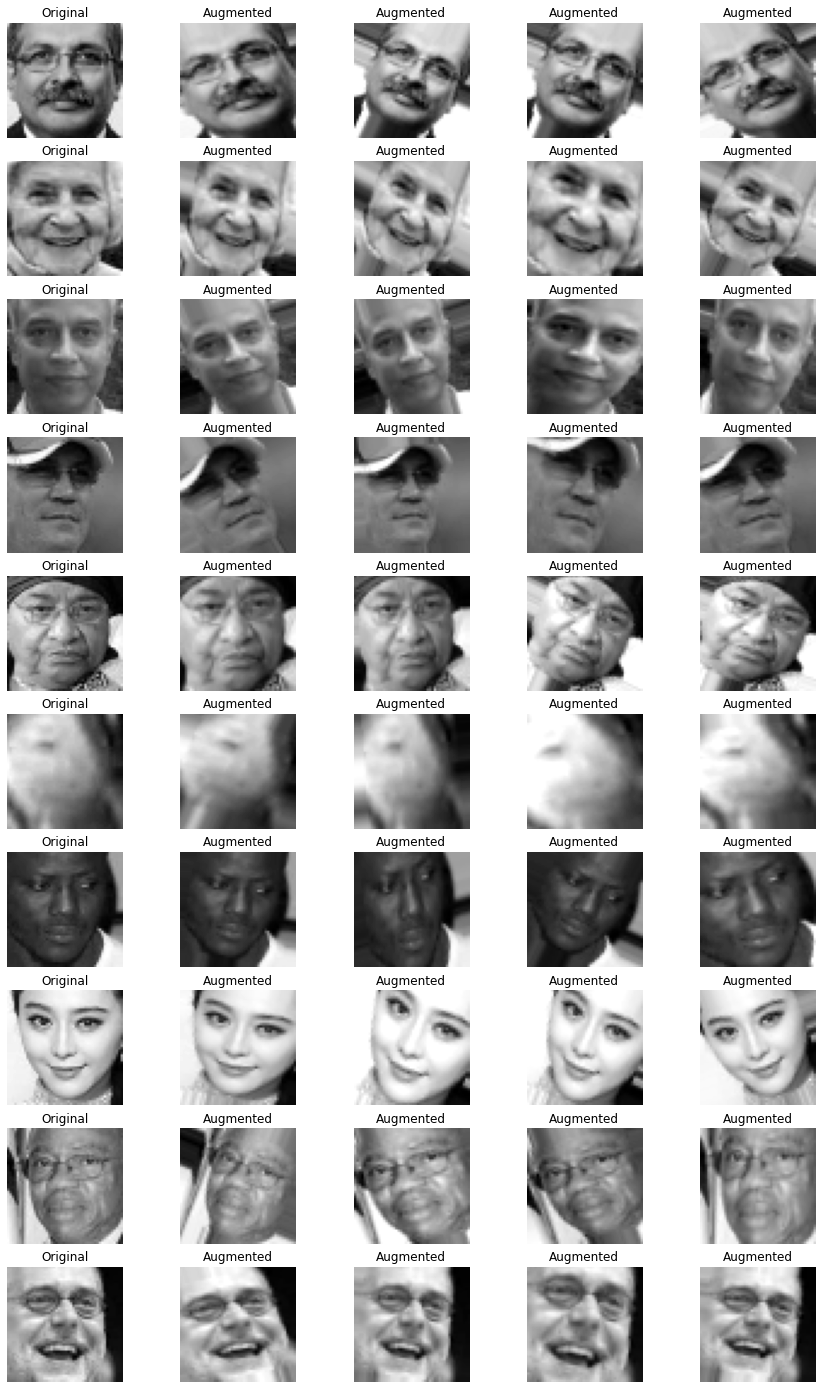

In [54]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

**Model Training**

In [64]:
# Model configuration
# Please note that number of epochs and folds were reduced to decrease training time
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 5
activation='softmax'


In [65]:
# Determining the shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [66]:
random.seed(11)
set_seed(11)
np.random.seed(11)

kfold = KFold(n_splits=num_folds, shuffle=True)

In [67]:
#Please note that the error below was because the cell was terminated early before completion

acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  random.seed(11)
  set_seed(11)
  np.random.seed(11)

  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test], seed=11))
  
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test], seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
487/487 [==============================] - 496s 1s/step - loss: 0.5775 - accuracy: 0.7650 - val_loss: 1.2184 - val_accuracy: 0.5615
Epoch 2/10
487/487 [==============================] - 494s 1s/step - loss: 0.3295 - accuracy: 0.8593 - val_loss: 0.2905 - val_accuracy: 0.8847
Epoch 3/10
487/487 [==============================] - 493s 1s/step - loss: 0.2926 - accuracy: 0.8787 - val_loss: 0.3105 - val_accuracy: 0.8768
Epoch 4/10
487/487 [==============================] - 491s 1s/step - loss: 0.2677 - accuracy: 0.8939 - val_loss: 0.2603 - val_accuracy: 0.8981
Epoch 5/10
487/487 [==============================] - 493s 1s/step - loss: 0.2527 - accuracy: 0.8973 - val_loss: 0.3302 - val_accuracy: 0.8639
Epoch 6/10
487/487 [==============================] - 491s 1s/step - loss: 0.2414 - accuracy: 0.9058 - val_loss: 0.2708 - val_accuracy: 0.8924
Epoch 7/10
487/487 [=========================

Score for fold 1: loss of 0.363099604845047; accuracy of 85.4942262172699%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
135/487 [=======>......................] - ETA: 5:31 - loss: 0.8780 - accuracy: 0.6285

KeyboardInterrupt: ignored

In [68]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.363099604845047 - Accuracy: 85.4942262172699%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 85.4942262172699 (+- 0.0)
> Loss: 0.363099604845047
------------------------------------------------------------------------


In [69]:
random.seed(11)
set_seed(11)
np.random.seed(11)
  
model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))

# Compile the model
model.compile(loss=loss_function, optimizer=optimizer,metrics=['accuracy'])


In [71]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val, seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=5, validation_data=val_data)

Epoch 1/5
609/609 [==============================] - 611s 1s/step - loss: 0.5404 - accuracy: 0.7410 - val_loss: 0.4285 - val_accuracy: 0.7980
Epoch 2/5
609/609 [==============================] - 615s 1s/step - loss: 0.3524 - accuracy: 0.8510 - val_loss: 0.2971 - val_accuracy: 0.8830
Epoch 3/5
609/609 [==============================] - 610s 1s/step - loss: 0.3060 - accuracy: 0.8739 - val_loss: 0.2750 - val_accuracy: 0.8918
Epoch 4/5
609/609 [==============================] - 614s 1s/step - loss: 0.2810 - accuracy: 0.8855 - val_loss: 0.2399 - val_accuracy: 0.9007
Epoch 5/5
609/609 [==============================] - 612s 1s/step - loss: 0.2636 - accuracy: 0.8940 - val_loss: 0.2770 - val_accuracy: 0.8951


In [72]:
fig = px.line(
final_model_history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'val_loss'}, 
title='Training History')
fig.show()

In [73]:
fig = px.line(
final_model_history.history, y=['accuracy', 'val_accuracy'],
labels={'index': 'epoch', 'value': 'accuracy'}, 
title='Training History')
fig.show()

In [75]:
model.evaluate(test_data)
y_pred = model.predict_classes(test_data)

print(classification_report(y_test, y_pred))

28/28 [==============================] - 6s 229ms/step - loss: 0.2619 - accuracy: 0.9054


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

           0       0.89      0.94      0.91       468
           1       0.93      0.86      0.89       409

    accuracy                           0.91       877
   macro avg       0.91      0.90      0.90       877
weighted avg       0.91      0.91      0.91       877



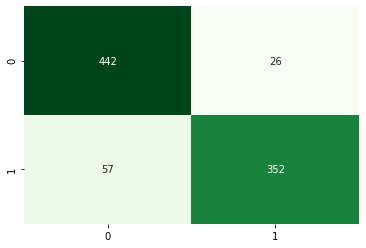

In [76]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

**Error Analysis**

In [77]:
error_index = (y_test != y_pred)
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

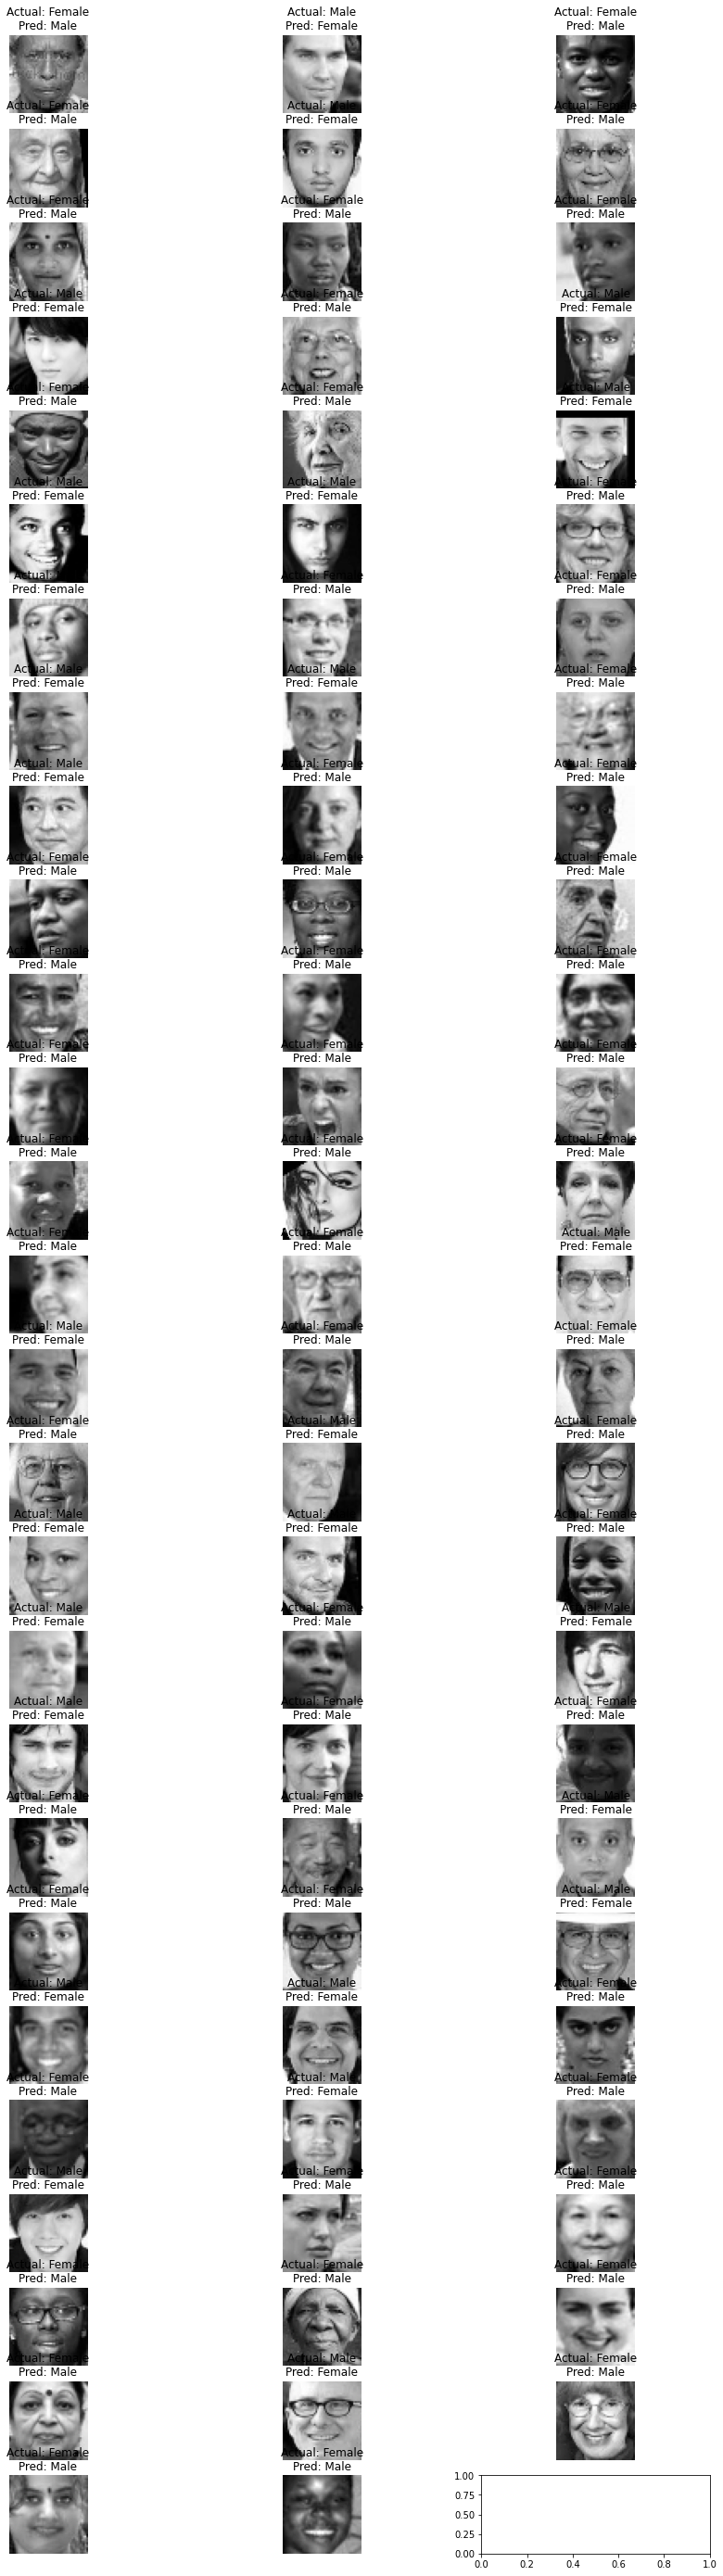

In [78]:
rows=int(np.floor(sum(error_index)/3))
cols=3 
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()